In [390]:
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [391]:
def generate_almost_orthogonal_embeddings(k, D, seed=None):
    rng = np.random.default_rng(seed)
    vecs = rng.normal(size=(k, D))
    # Normalisation
    vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)
    return vecs.astype(np.float32)


In [392]:
def orthogonality_score(embeddings):
    dot_prods = embeddings @ embeddings.T
    np.fill_diagonal(dot_prods, 0)
    return np.max(np.abs(dot_prods))


In [393]:
T = 20
k = 26
D = 2000

In [394]:
embeddings = generate_almost_orthogonal_embeddings(1+k+T, D//2, seed=0)

In [546]:
def generate_dict(k, D):
    assert D % 2 == 0, "D doit être divisible par 2"
    letters = list(string.ascii_uppercase)
    assert k <= len(letters), "k ne doit pas dépasser 26"

    dico = {}

    # Ajout du token 'b' (begin)
    begin_half = embeddings[0]
    begin_vec = np.concatenate([begin_half, np.zeros(D // 2, dtype=np.float32)])
    dico['b'] = begin_vec

    # Ajout des k lettres
    for i in range(k):
        key = letters[i]
        half = embeddings[i + 1]
        vec = np.concatenate([half, np.zeros(D // 2, dtype=np.float32)])
        dico[key] = vec

    return dico

In [547]:
dic = generate_dict(k, D)

In [548]:
dic['C'] @ dic['C'].T

1.0

In [549]:
def string_to_token(s):
    return np.array([dic[c] for c in s]).astype(np.float32)

In [550]:
def softmax(x, axis=None):
    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

In [653]:

string_seq = ['b', 'C', 'A', 'E', 'C', 'H', 'E', 'A', 'A', 'D', 'B', 'H']
T = len(string_seq)

In [654]:
P = np.zeros((T, D), dtype=np.float32)
for i in range(T):
    half = embeddings[k + i + 1]
    P[i] = np.concatenate([half, np.zeros(D // 2, dtype=np.float32)])

In [655]:
P[0] @ P[1].T

-0.0454307

In [656]:
def permutation_matrix(D):
    assert D % 2 == 0, "D doit être pair"
    d_half = D // 2
    V = np.zeros((D, D))

    # Remplit les blocs pour permuter les deux moitiés
    V[:d_half, d_half:] = np.eye(d_half)  # Haut droit
    V[d_half:, :d_half] = np.eye(d_half)  # Bas gauche

    return V

In [657]:
def embedding(P, S):
    T = S.shape[0]
    return P[:T,:]+S

In [658]:
def first_layer(P, S):
    X = embedding(P, S)
    QK1 = np.zeros((D,D), dtype=np.float32)
    for i in range(1, len(P)):
        QK1 = QK1 + (P[i].reshape(D, 1) @ P[i-1].reshape(1, D))
    
    Att = X @ QK1 @ (X.T)/ np.linalg.norm(X @ QK1 @ (X.T)) * 20
    Att = softmax(Att, axis=1)
    V = permutation_matrix(D)
    Z = (Att @ X @ V)/np.linalg.norm(Att @ X @ V)+X/np.linalg.norm(X)
    return Att, Z

In [659]:
Att1, Z1 = first_layer(P, string_to_token(string_seq))
Z1

array([[ 6.22970005e-03, -1.07063148e-02,  9.11480095e-03, ...,
        -5.18664463e-03, -3.71283657e-03, -1.21414511e-03],
       [ 7.29362131e-04,  1.15148583e-03, -8.39463144e-04, ...,
         1.19379844e-03, -7.05947057e-03,  7.09772323e-05],
       [ 8.06162413e-03, -4.10491461e-03, -3.16658476e-03, ...,
         9.72683577e-04,  1.28799464e-02, -4.02636269e-03],
       ...,
       [ 8.34707357e-03, -1.84064644e-04, -8.59266985e-03, ...,
        -1.32173684e-02, -1.84319332e-03,  3.70909753e-03],
       [-1.40255932e-02, -5.02112601e-03,  1.30120362e-03, ...,
        -1.88944518e-02, -1.28377493e-02, -9.14895654e-03],
       [ 2.20385916e-03, -1.46633945e-02, -1.69974775e-03, ...,
        -1.49904106e-02, -4.05636601e-03,  5.15186919e-03]])

In [660]:
def display_matrix(Att, string_seq):
    plt.figure(figsize=(8, 6))
    sns.heatmap(Att, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=string_seq, yticklabels=string_seq)
    plt.title("Attention Matrix")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.show()


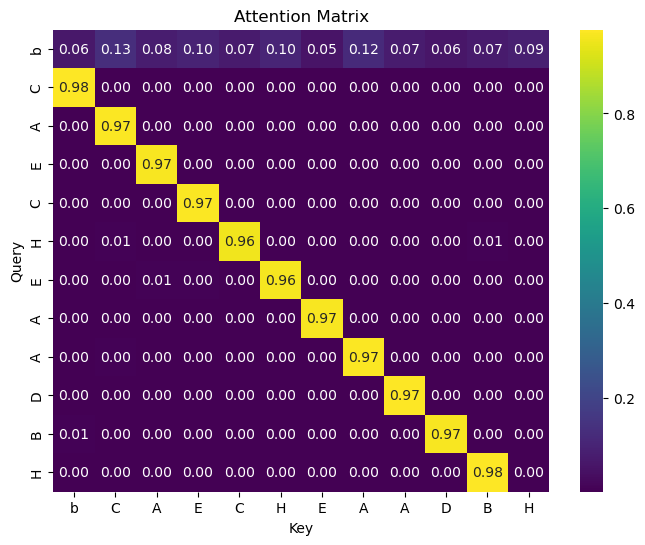

In [661]:
display_matrix(Att1, string_seq)

In [662]:
def second_layer(Z, beta=1):
    K_2 = np.zeros((D, D), dtype=np.float32)
    K_2[:D//2, D//2:] = np.eye(D//2)  
    Att2 = Z @ (K_2) @ (Z.T) *100
    Att2 = softmax(Att2, axis=1)
    V2 = beta* np.eye(D)
    Z2 = (Att2 @ Z @ V2)/np.linalg.norm(Att2 @ Z)
    return Att2, Z2


In [663]:
Att2, Z2 = second_layer(Z1)

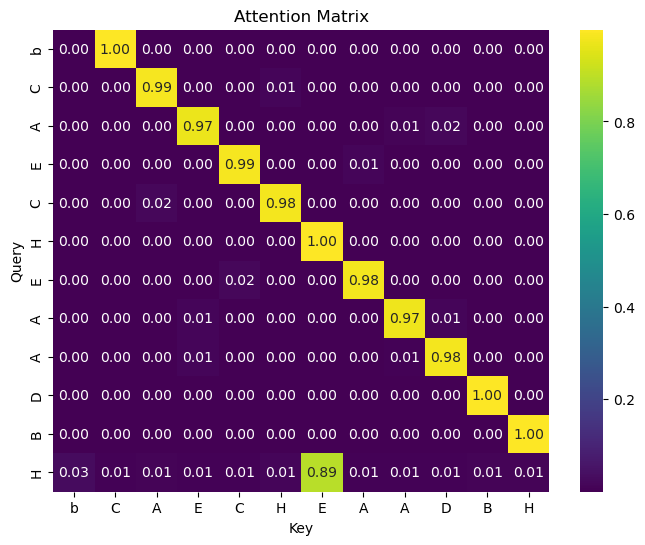

In [664]:
display_matrix(Att2, string_seq)

In [665]:
def classification(k, dico, Z):
    mlp = np.zeros((k, D), dtype=np.float32)
    letters = list(string.ascii_uppercase)
    for i in range(k):
        key = letters[i]
        mlp[i] = dico[key] *30
    logits = mlp @ Z[-1].T
    return softmax(logits)
    

In [666]:
classification_result = classification(k, dic, Z2)
print("Classification result", classification_result)

Classification result [0.01339951 0.01448805 0.01254738 0.01196919 0.62477017 0.01678739
 0.02054357 0.01450899 0.01318539 0.01828388 0.02058337 0.01542992
 0.01080342 0.01545548 0.01219204 0.01639658 0.01620089 0.01374616
 0.01705527 0.01484959 0.0098792  0.01407867 0.01312595 0.01543885
 0.01905612 0.01522498]


In [677]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import string

def plot_output(output, k):
    letters = list(string.ascii_uppercase[:k])
    df = pd.DataFrame({'Lettre': letters, 'Probabilité': output})

    plt.figure(figsize=(8, 4))
    sns.barplot(data=df, x='Lettre', y='Probabilité')
    plt.title("Distribution des probabilités (softmax)")
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.show()


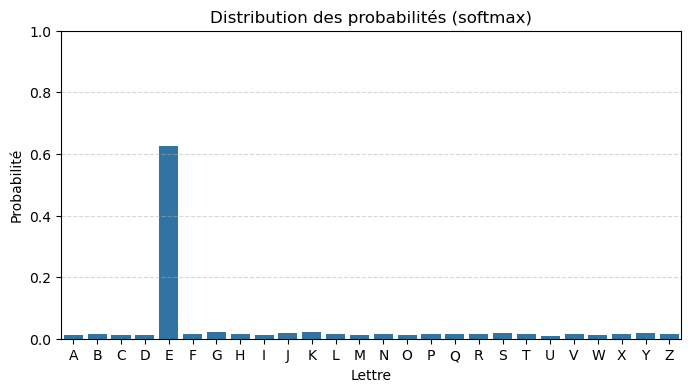

In [678]:
plot_output(classification_result, k)

In [667]:
def generate_X_y(T, dico, n):
    """
    Génère n séquences (X, y) :
    - X est une séquence de T+1 lettres : 'b', ..., target (qui apparaît deux fois)
    - y est la lettre juste après la première apparition du target
    """
    assert 'b' in dico
    letters = [k for k in dico if k != 'b']
    assert len(letters) >= 2
    assert T >= 3, "T doit être au moins 3 pour que target puisse apparaître avant la fin et être suivi"

    X_list = []
    y_list = []

    for _ in range(n):
        seq = ['b']
        target = random.choice(letters)

        # Position du target dans le corps, garanti < T - 1
        insert_pos = random.randint(1, T - 2)

        middle_letters = []
        for i in range(1, T):
            if i == insert_pos:
                middle_letters.append(target)
            else:
                other_choices = [l for l in letters if l != target]
                middle_letters.append(random.choice(other_choices))

        seq.extend(middle_letters)
        seq.append(target)  # target en dernière position

        y = middle_letters[insert_pos]
        X_list.append(seq)
        y_list.append(y)

    return X_list, y_list


In [668]:
def model(S):
    Att1, Z1 = first_layer(P, S)
    Att2, Z2 = second_layer(Z1)
    logits = classification(k, dic, Z2)
    return logits

In [669]:
P.shape, string_to_token(string_seq).shape

((12, 2000), (12, 2000))

In [670]:
model(string_to_token(string_seq))

array([0.01339951, 0.01448805, 0.01254738, 0.01196919, 0.62477017,
       0.01678739, 0.02054357, 0.01450899, 0.01318539, 0.01828388,
       0.02058337, 0.01542992, 0.01080342, 0.01545548, 0.01219204,
       0.01639658, 0.01620089, 0.01374616, 0.01705527, 0.01484959,
       0.0098792 , 0.01407867, 0.01312595, 0.01543885, 0.01905612,
       0.01522498])

In [699]:
import numpy as np

def display_predictions_numpy(X_seq, y_true, model, char_to_int, int_to_char):
    """
    X_seq : liste de séquences de lettres (n x (T+1))
    y_true : liste de lettres (n)
    model  : fonction prenant S (n, T+1) indices → logits (n, k)
    Retourne l'affichage coloré dans le terminal.
    """
    error = 0
    BLUE  = '\033[94m'
    GREEN = '\033[92m'
    RESET = '\033[0m'

    # Conversion une fois des séquences en indices
    S_list = [string_to_token(x) for x in X_seq]  # shape (n, T+1)

    for i, S in enumerate(S_list):
        logits = model(S)             # shape (1, k) ou (k,)
        # si model renvoie (1,k), on aplatit :
        logits = logits.flatten()
        y_pred_idx = np.argmax(logits)
        pred_letter = int_to_char[y_pred_idx+1]
        true_letter = y_true[i]

        x_letters = X_seq[i]
        last = x_letters[-1]
        # trouver position unique de last dans le préfixe (sans compter b)
        other_pos = next(j for j, c in enumerate(x_letters[1:-1], start=1) if c == last)

        # marquer la séquence
        colored = []
        for j, c in enumerate(x_letters[1:], start=1):  # on ignore le 'b' à j=0
            if j == other_pos or j == len(x_letters)-1:
                # soit la première occurrence du last, soit la dernière
                colored.append(f"{BLUE}{c}{RESET}")
            elif c == true_letter:
                colored.append(f"{GREEN}{c}{RESET}")
            else:
                colored.append(c)

        print(f"Sequence : {''.join(colored)}")
        print(f"  True : {GREEN}{true_letter}{RESET}, Predicted : {GREEN}{pred_letter}{RESET}")

        # compter les erreurs
        if logits.max() < 0.5 or pred_letter != true_letter:
            error += 1

    print(f"\nErreur : {error} / {len(X_seq)} séquences")


In [672]:
T=10
X_seq, y = generate_X_y(T=T, dico=dic, n=30)


In [700]:
char_to_int = {c: i for i, c in enumerate(dic)}
int_to_char = {i: c for c, i in char_to_int.items()}


display_predictions_numpy(X_seq[:30], y, model, char_to_int, int_to_char)


Sequence : GMHKWKOFCM
  True : H, Predicted : H
Sequence : BYDCRIFLQI
  True : F, Predicted : F
Sequence : TKPJXTLUKU
  True : K, Predicted : K
Sequence : ICHUYRMVPH
  True : U, Predicted : U
Sequence : LWBBPZMMQL
  True : W, Predicted : W
Sequence : RVYOOLWIXL
  True : W, Predicted : W
Sequence : XWNPNRTITP
  True : N, Predicted : N
Sequence : RYPSUHTWGP
  True : S, Predicted : S
Sequence : UEEOGUKNDO
  True : G, Predicted : G
Sequence : OKUHMNCXZH
  True : M, Predicted : M
Sequence : PLXTGLMVZM
  True : V, Predicted : V
Sequence : PVBSCOJMXC
  True : O, Predicted : O
Sequence : FITHGMARGI
  True : T, Predicted : T
Sequence : NZUAGTPCBZ
  True : U, Predicted : U
Sequence : RSFUTGLANA
  True : N, Predicted : N
Sequence : DBKCFAXTUC
  True : F, Predicted : F
Sequence : VJMTPWRNWM
  True : T, Predicted : T
Sequence : EBTQSHPYIQ
  True : S, Predicted : S
Sequence : WNDQYZTUGZ
  True : T, Predicted : T
Sequence : CBWINUDFLD
  True : F, Predicted : F
Sequence : JZSOQXZJFO
  True : Q, Predic

In [674]:
def generate_X(T, dico, n):
    """
    Génère n séquences X de longueur T+1 :
    - Chaque séquence commence par 'b'
    - La dernière lettre (position T) n’apparaît pas ailleurs dans la séquence
    - Il n'y a pas de sortie y associée
    """
    assert 'b' in dico
    letters = [k for k in dico if k != 'b']
    assert len(letters) >= 2
    assert T >= 2

    X_list = []

    for _ in range(n):
        while True:
            seq = ['b']
            candidate_last = random.choice(letters)

            # lettres disponibles pour le corps de la séquence (T-1 lettres après 'b')
            other_choices = [l for l in letters if l != candidate_last]
            middle_letters = [random.choice(other_choices) for _ in range(T - 1)]

            if candidate_last not in middle_letters:
                # on valide la séquence
                seq.extend(middle_letters)
                seq.append(candidate_last)
                X_list.append(seq)
                break  # passer à la suivante

    return X_list


In [675]:
X_no_repeat = generate_X(T=10, dico=dic, n=300)

In [676]:
# for i, x in enumerate(X_no_repeat):
#     pass
#     if (max(model(string_to_token(x)))) > 0.3:
#         print(x)
#         print(model(string_to_token(x)))
#         print(max(model(string_to_token(x))))